## Description:

    Ordinate enzyme data
    Regress axes against OTU abundance in DESeq


# Setting variables

In [39]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [40]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", "lmerTest",
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "lmerTest"
[1] ‘2.0.33’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [42]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [43]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [44]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [65]:
%%R

#remove BARE soil controls and untreated seeds
physeq.plant = subset_samples(physeq.Full, Genotype != "Bare" & SeedTreatment == "Treated")


# Remove ordination outliers, see Ordination notebook
#physeq.plant = subset_samples(physeq.plant, !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# Set rep as a factor
sample_data(physeq.plant)$Rep = factor(sample_data(physeq.plant)$Rep)   
sample_data(physeq.plant)$ERA = factor(sample_data(physeq.plant)$ERA)  
sample_data(physeq.plant)$Fert = factor(sample_data(physeq.plant)$Fert)  


physeq.plant


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 195 samples ]
sample_data() Sample Data:       [ 195 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


# Ordinate enzyme data - all timepoints

In [66]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant), "data.frame")
rownames(sd) = sd$X.sample

tmp = filter(sd, X.sampleID != "ERA-T1_4-5b_85")

tmp %>% select(BG_activity.g, BX_activity.g,CB_activity.g, LAP_activity.g, NAG_activity.g) %>%
    as.matrix %>%
Hmisc::rcorr()

               BG_activity.g BX_activity.g CB_activity.g LAP_activity.g
BG_activity.g           1.00          0.75          0.82           0.39
BX_activity.g           0.75          1.00          0.88           0.58
CB_activity.g           0.82          0.88          1.00           0.48
LAP_activity.g          0.39          0.58          0.48           1.00
NAG_activity.g          0.71          0.68          0.80           0.52
               NAG_activity.g
BG_activity.g            0.71
BX_activity.g            0.68
CB_activity.g            0.80
LAP_activity.g           0.52
NAG_activity.g           1.00

n= 193 


P
               BG_activity.g BX_activity.g CB_activity.g LAP_activity.g
BG_activity.g                 0             0             0            
BX_activity.g   0                           0             0            
CB_activity.g   0             0                           0            
LAP_activity.g  0             0             0                          
NAG_activity.g 

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.7009 0.8229 0.52376 0.39440
Proportion of Variance 0.7233 0.1693 0.06858 0.03889
Cumulative Proportion  0.7233 0.8925 0.96111 1.00000
                     PC1        PC2         PC3         PC4
BG_activity.g  0.5168354 -0.3690584  0.59592858  0.49147344
CB_activity.g  0.5463101 -0.2281931  0.04832181 -0.80444901
LAP_activity.g 0.3911485  0.8983978  0.19841493  0.02270873
NAG_activity.g 0.5304991 -0.0678613 -0.77663740  0.33286626


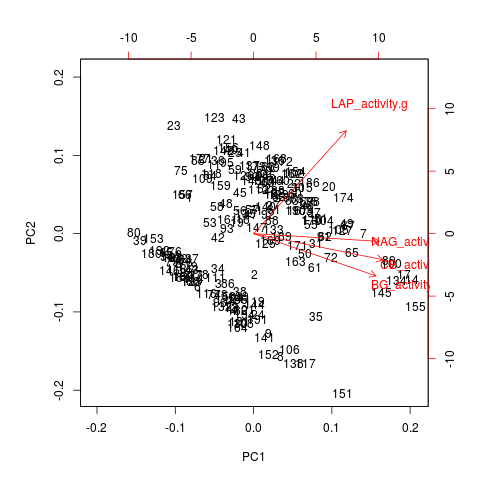

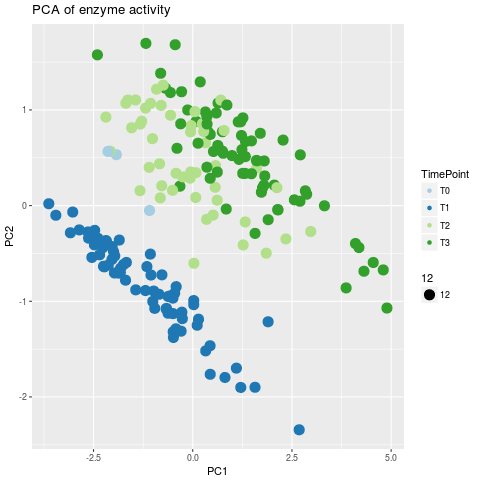

In [67]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant), "data.frame")
rownames(sd) = sd$X.sample

tmp = filter(sd, X.sampleID != "ERA-T1_4-5b_85")
fit = prcomp(~BG_activity.g +  CB_activity.g + LAP_activity.g + NAG_activity.g, data = tmp, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(tmp, S)
# rownames(TM_Fit) = TM_Fit$X.sample
# sample_data(physeq.plant) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, color = TimePoint, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p

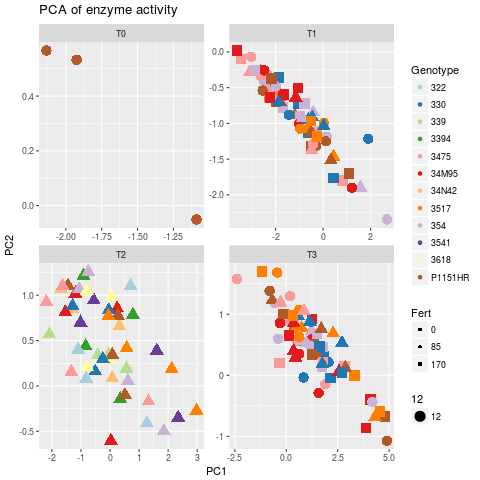

In [68]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Genotype, shape = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p = p + facet_wrap(~TimePoint, scales = "free")
p

### Join enzyme ordination scores with phyloseq object

In [69]:
%%R
PCscore = TM_Fit %>%
    select(X.sampleID, PC1, PC2, PC3)
colnames(PCscore)[2:4] = c("EnzPC1", "EnzPC2", "EnzPC3")

In [70]:
%%R
sd = left_join(sd, PCscore, by = "X.sampleID")
rownames(sd) = sd$X.sampleID
physeq.plantenz = physeq.plant
sample_data(physeq.plantenz) = sd

# Core sample enzyme analysis

* Note that we did not ordinate bare soil samples as well, may want to redo:

In [71]:
%%R
Data.c = sd %>% filter(Genotype %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & Fert == "85" 
                       & !is.na(BG_activity.g)) %>%
    mutate(R_Year.c = R_Year - 1935)
dim(Data.c)
colnames(Data.c)

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"       "Rep"            
[17] "Row"             "Pos"             "Fert"            "PlotIndex"      
[21] "Plant"           "Genotype"        "SeedTreatment"   "R_Year"         
[25] "ERA"             "BG_activity.g"   "BX_activity.g"   "CB_activity.g"  
[29] "LAP_activity.g"  "NAG_activity.g"  "Stage"           "kgdw_ha"        
[33] "FracN.leco"      "FracC.leco"      "kgN_ha"          "RGR"            
[37] "AGR"             "Nprod"           "NupR"            "d15N"           
[41] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 
[45] "kgFertN_ha"      "kgSoilN_ha"      "EnzPC1"          "EnzPC2"         
[49] "EnzPC3"          "R_Year.c"       


In [72]:
%%R
m1 = lmer(EnzPC1~Genotype*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = Data.c, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(EnzPC2~Genotype*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = Data.c, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
Genotype           17.708  3.5415     5 14.888   4.036   0.01623 *  
TimePoint          58.170 29.0848     2 35.442  33.148 7.663e-09 ***
Genotype:TimePoint  6.192  0.6192    10 35.381   0.706   0.71290    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
Genotype            0.6991  0.1398     5 14.897   0.667    0.6547    
TimePoint          31.0171 15.5085     2 35.442  73.937 2.254e-13 ***
Genotype:TimePoint  0.6330  0.0633    10 35.381   0.302    0.9760    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [73]:
%%R
m1 = lmer(EnzPC1~R_Year.c*TimePoint + (1|Rep) + (1|Genotype) + (1|Rep:Genotype),  data = Data.c, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(EnzPC2~R_Year.c*TimePoint + (1|Rep) + (1|Genotype) + (1|Rep:Genotype),  data = Data.c, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
R_Year.c            0.3781  0.3781     1  3.998  0.4442 0.541595   
TimePoint          12.7999  6.3999     2 43.088  7.5183 0.001582 **
R_Year.c:TimePoint  0.3676  0.1838     2 43.378  0.2159 0.806671   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
R_Year.c            0.0064  0.0064     1  3.988  0.0345    0.8617    
TimePoint          10.1288  5.0644     2 43.100 27.4575 2.045e-08 ***
R_Year.c:TimePoint  0.0737  0.0369     2 43.406  0.1999    0.8196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* Within core plants there is no effect of year of release, but there is a genotype effect
* No year of release effect within core plots over time

## DESeq of Enzymes (Re-run without BX in ordination)

In [36]:
%%R
sample_data(physeq.plantenz)$Rep = as.factor(sample_data(physeq.plantenz)$Rep)
sample_data(physeq.plantenz)$Fert = as.factor(sample_data(physeq.plantenz)$Fert)
sample_data(physeq.plantenz)$ERA = as.factor(sample_data(physeq.plantenz)$ERA)
sample_data(physeq.plantenz)$R_Year.c = sample_data(physeq.plantenz)$R_Year - R_Year.c

In [45]:
%%R
t.df = tax_table(physeq.plantenz) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [41]:
%%R
phyEnz = subset_samples(physeq.plantenz, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC1"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 105, 2.3% 
LFC < 0 (down)   : 71, 1.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 2048, 45% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


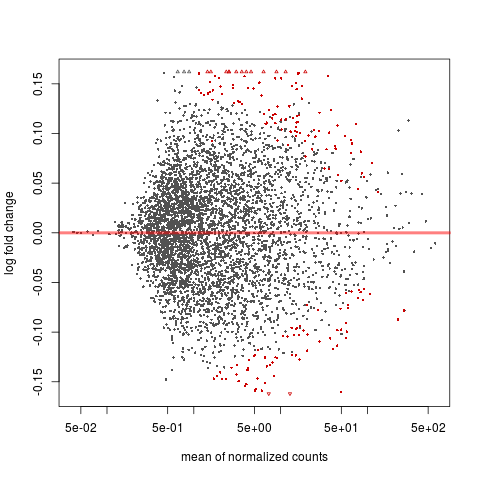

In [48]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [53]:
%%R
register(MulticoreParam(20))
phyEnz = subset_samples(physeq.plant, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC2"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 177, 3.9% 
LFC < 0 (down)   : 116, 2.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 1692, 37% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


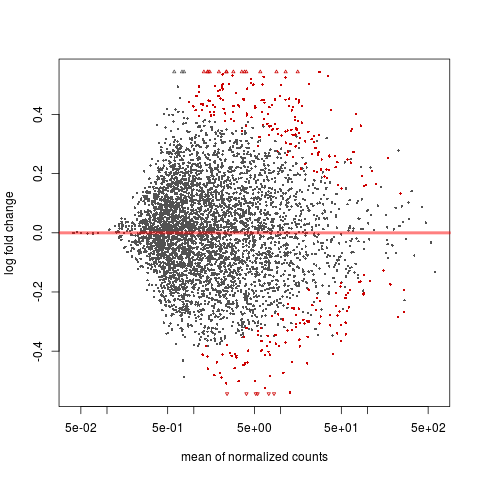

In [58]:
%%R
EnzRes2 = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes2) %>% print
plotMA(EnzRes2)

EnzRes2$OTU = rownames(EnzRes2)
df_pc2 = EnzRes2 %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [59]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

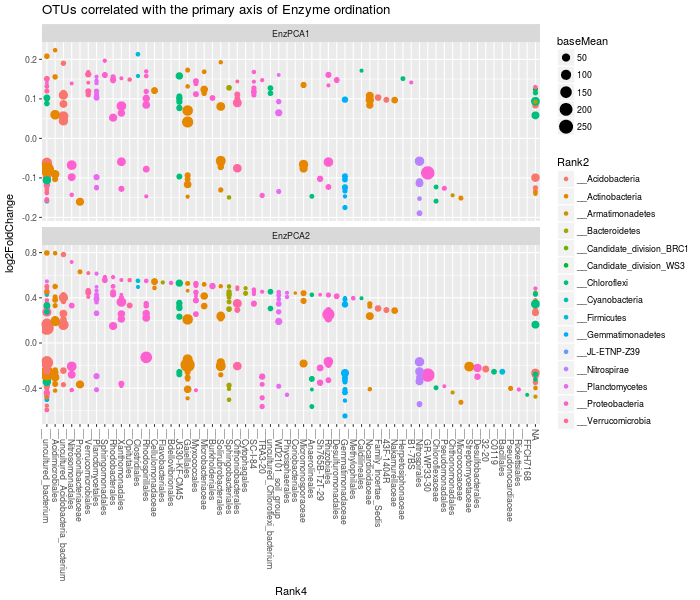

In [62]:
%%R -w 700 -h 600
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [64]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_EnzOrd_sig.csv', row.names = FALSE)

# Ordinate enzyme data - timepoints seperately

## T1

In [81]:
%%R
physeq.plant.t1 = subset_samples(physeq.plant, TimePoint == "T1" & !X.sampleID %in%  
                                 c("ERA-T1_3-5c_0","ERA-T1_4-5b_85")) # removing two multivariate outliers, 
                                                                    #run with samples to visualize
physeq.plant.t1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 70 samples ]
sample_data() Sample Data:       [ 70 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.8415 0.6458 0.40380 0.16960
Proportion of Variance 0.8478 0.1043 0.04076 0.00719
Cumulative Proportion  0.8478 0.9520 0.99281 1.00000
                     PC1        PC2         PC3         PC4
BG_activity.g  0.4953908  0.4392308 -0.72795055  0.17819175
CB_activity.g  0.4837800  0.5663562  0.66703969 -0.01598999
LAP_activity.g 0.4993322 -0.5788197  0.14436642  0.62832592
NAG_activity.g 0.5207805 -0.3889534 -0.06560779 -0.75709878


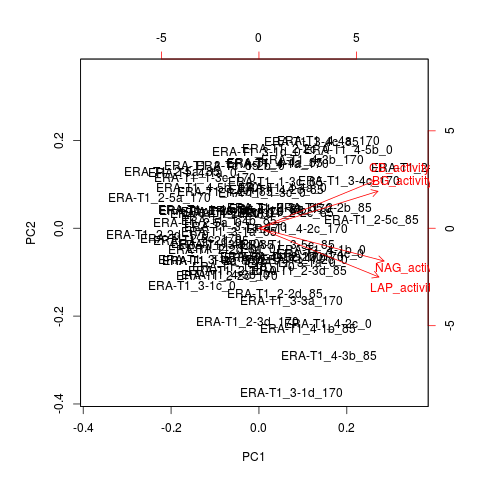

In [82]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t1), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t1) = TM_Fit

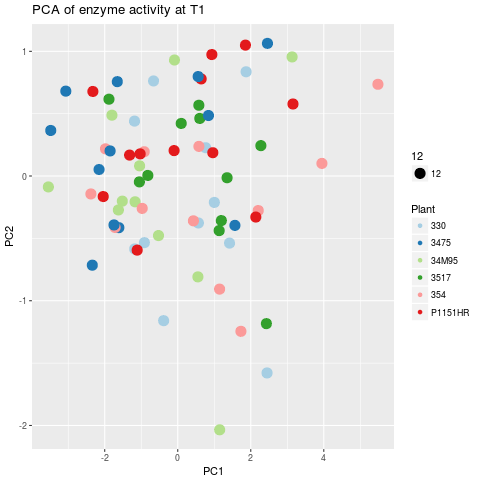

In [83]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T1")
p

## Treatment effects at T1

In [87]:
%%R

m1 = lmer(PC1~Genotype + Fert + (1|Rep) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~Genotype + Fert + (1|Rep) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
Genotype 12.3965  2.4793     5 14.907  1.0704 0.4153
Fert      3.5671  1.7835     2 43.759  0.7700 0.4692
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
Genotype 2.12031 0.42406     5 14.815 1.13148 0.3866
Fert     0.23767 0.11883     2 44.140 0.31707 0.7299


In [92]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~R_Year.c *Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c * Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      2.9665 2.96649     1  3.921 1.29385 0.3200
Fert          2.0774 1.03869     2 28.875 0.45303 0.6401
R_Year.c:Fert 1.4069 0.70345     2 40.443 0.30681 0.7375
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      1.40646 1.40646     1  3.844  4.0025 0.1189
Fert          0.05422 0.02711     2 29.179  0.0772 0.9259
R_Year.c:Fert 0.26546 0.13273     2 40.342  0.3777 0.6878


## DESeq of T1 enzymes

In [140]:
%%R
sample_data(physeq.plant.t1)$Rep = as.factor(sample_data(physeq.plant.t1)$Rep)
sample_data(physeq.plant.t1)$Fert = as.factor(sample_data(physeq.plant.t1)$Fert)
sample_data(physeq.plant.t1)$ERA = as.factor(sample_data(physeq.plant.t1)$ERA)
sample_data(physeq.plant.t1)$R_Year.c = sample_data(physeq.plant.t1)$R_Year - 1935

In [141]:
%%R
t.df = tax_table(physeq.plant.t1) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [142]:
%%R
tmp.1 = subset_samples(physeq.plant.t1, !is.na(PC1))
dds = phyloseq_to_deseq2(tmp.1, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 12, 0.26% 
LFC < 0 (down)   : 2, 0.044% 
outliers [1]     : 0, 0% 
low counts [2]   : 3197, 70% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


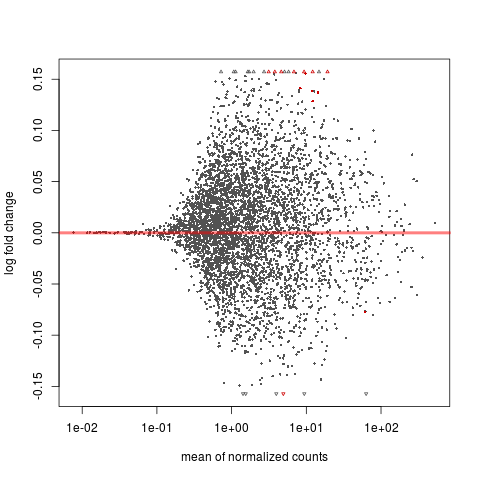

In [143]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [98]:
# %%R

# dds = phyloseq_to_deseq2(tmp.1, ~Rep + PC2)
# d_dds = DESeq(dds, parallel = TRUE)
# resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC2"      



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


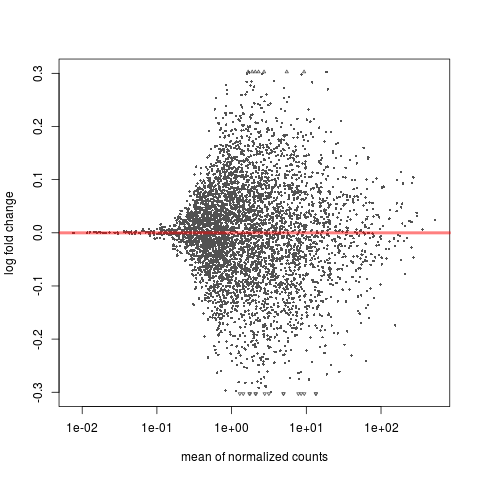

In [144]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [145]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

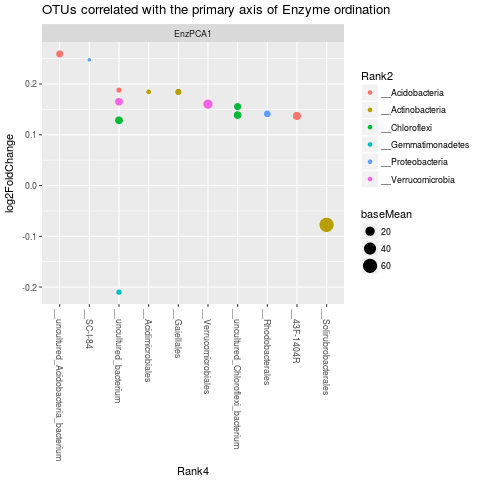

In [146]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [147]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t1_sig.csv', row.names = FALSE)

## T2

In [148]:
%%R
physeq.plant.t2 = subset_samples(physeq.plant, TimePoint == "T2")
physeq.plant.t2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.6014 0.9071 0.6865 0.37592
Proportion of Variance 0.6411 0.2057 0.1178 0.03533
Cumulative Proportion  0.6411 0.8468 0.9647 1.00000
                      PC1         PC2        PC3        PC4
BG_activity.g  -0.5063525  0.49724617 -0.4568629  0.5363112
CB_activity.g  -0.5889930  0.02225761 -0.2315146 -0.7739463
LAP_activity.g -0.3791698 -0.85886677 -0.1515724  0.3091988
NAG_activity.g -0.5029161  0.12082519  0.8454011  0.1333176


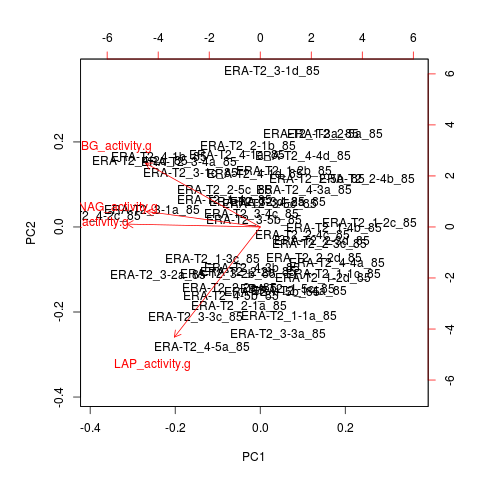

In [149]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t2), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g  + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t2) = TM_Fit


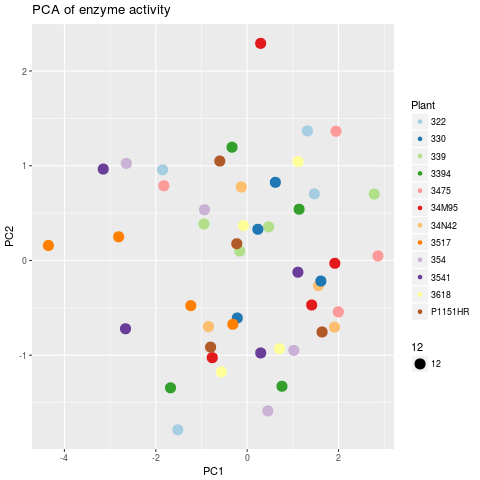

In [150]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p

## Treatment effects at T2

In [151]:
%%R

m1 = lmer(PC1~Genotype  + (1|Rep),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~Genotype  + (1|Rep),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
         Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Genotype 37.572  3.4157    11    33  2.2634 0.03453 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
         Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
Genotype 2.9862 0.27147    11    33 0.27386 0.9868


In [152]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~R_Year.c + (1|Rep),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c  + (1|Rep),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c 0.50152 0.50152     1    43 0.24825 0.6209
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c 0.31533 0.31533     1    43 0.37816 0.5418


* Genotype effect, but no relationship to year of releaese.
* Also checked polynomial with year of release, but no  dice

## DESeq of T2 enzymes

In [153]:
%%R
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$ERA = as.factor(sample_data(physeq.plant.t2)$ERA)
sample_data(physeq.plant.t2)$R_Year.c = sample_data(physeq.plant.t2)$R_Year - 1935

In [154]:
%%R
t.df = tax_table(physeq.plant.t2) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [155]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t2, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 1, 0.022% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


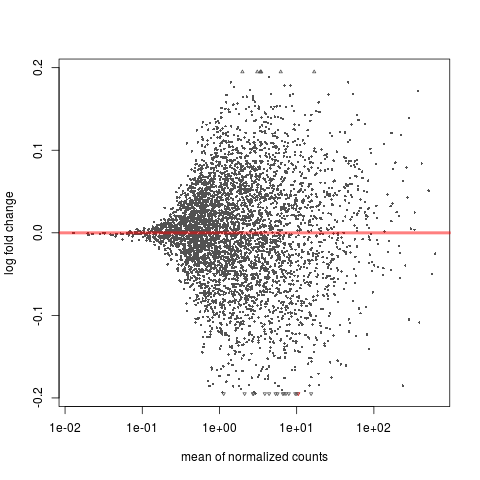

In [156]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [130]:
#%%R

# dds = phyloseq_to_deseq2(physeq.plant.t2, ~PC2)
# d_dds = DESeq(dds, parallel = TRUE)
# resultsNames(d_dds) %>% print

[1] "Intercept" "PC2"      



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 1, 0.022% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


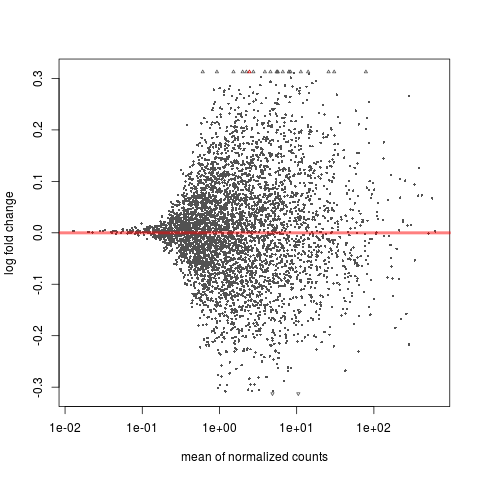

In [157]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [158]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

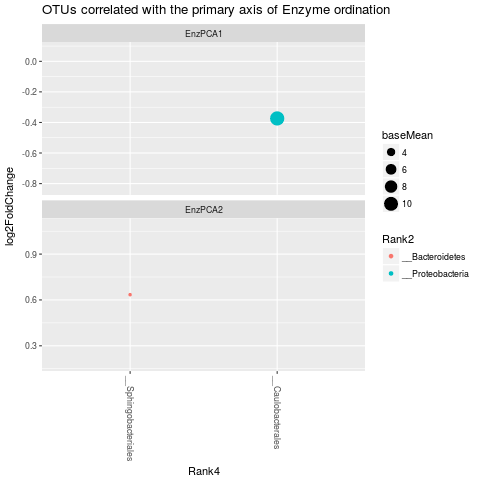

In [159]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [160]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t2_sig.csv', row.names = FALSE)

## Deseq of Enzyme ordination and MCC at T3

In [161]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
physeq.plant.t3

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.6225 1.0105 0.47848 0.34303
Proportion of Variance 0.6581 0.2553 0.05724 0.02942
Cumulative Proportion  0.6581 0.9133 0.97058 1.00000
                      PC1         PC2         PC3        PC4
BG_activity.g  -0.5730204  0.06398277 -0.68969419  0.4380362
CB_activity.g  -0.5918057 -0.04136671 -0.02321411 -0.8046838
LAP_activity.g -0.2266984  0.90510393  0.34238040  0.1103194
NAG_activity.g -0.5196359 -0.41830836  0.63761955  0.3852765


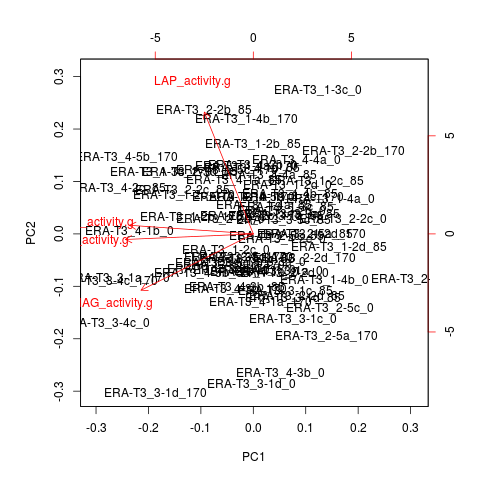

In [162]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t3), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t3) = TM_Fit


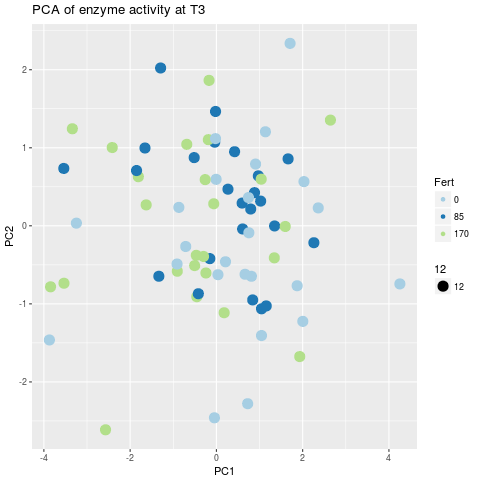

In [163]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T3") 
p

## Treatment effects at T3

In [167]:
%%R

m1 = lmer(PC1~Genotype*Fert + (1|Rep) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~Genotype*Fert + (1|Rep) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)  
Genotype       8.2253  1.6451     5    15  0.7079 0.6266  
Fert          14.9120  7.4560     2    36  3.2086 0.0522 .
Genotype:Fert  9.2472  0.9247    10    36  0.3979 0.9389  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Genotype      3.9679 0.79359     5    15  1.5027 0.24734  
Fert          3.4856 1.74279     2    36  3.3001 0.04831 *
Genotype:Fert 3.9512 0.39512    10    36  0.7482 0.67541  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [168]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~R_Year.c*Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c * Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c      0.35731 0.35731     1     4 0.17017 0.7011
Fert          2.13445 1.06722     2    44 0.50826 0.6050
R_Year.c:Fert 0.51327 0.25663     2    44 0.12222 0.8853
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c      0.47564 0.47564     1     4 0.92139 0.3915
Fert          1.93497 0.96749     2    44 1.87415 0.1655
R_Year.c:Fert 0.24910 0.12455     2    44 0.24127 0.7867


## DESeq of T3 enzymes

In [169]:
%%R
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$ERA = as.factor(sample_data(physeq.plant.t3)$ERA)
sample_data(physeq.plant.t3)$R_Year.c = sample_data(physeq.plant.t3)$R_Year - 1935

In [170]:
%%R
t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [171]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t3, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 9, 0.2% 
LFC < 0 (down)   : 9, 0.2% 
outliers [1]     : 0, 0% 
low counts [2]   : 4004, 87% 
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


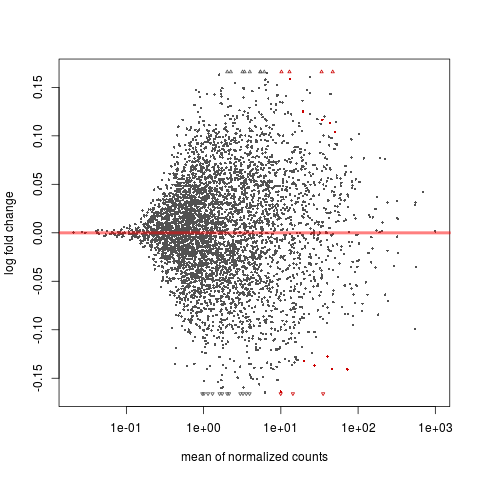

In [172]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")


out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


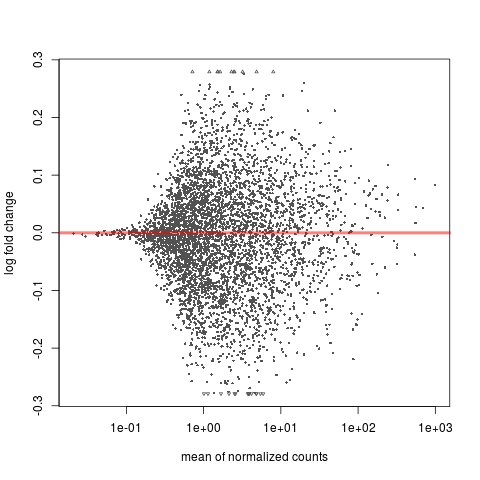

In [173]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [174]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

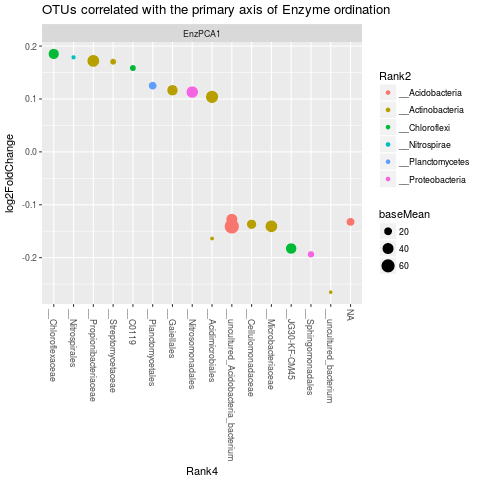

In [175]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2

In [176]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t3_sig.csv', row.names = FALSE)